# Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras import KerasTensor
from keras.api.models import Sequential, Model, model_from_json
from keras.api.optimizers import Adam
from keras.api.metrics import BinaryAccuracy, RootMeanSquaredError
from keras.api.losses import BinaryCrossentropy, Hinge
from keras.api.layers import Dense, Dropout, Add, Input
# Layers for preprocessing
from keras.api.layers import Rescaling, Resizing, RandomFlip, RandomRotation, \
    RandomTranslation, RandomZoom, RandomCrop, RandomBrightness, RandomContrast

from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.preprocessing import LabelEncoder

from utils.model_utils import print_history, plot_history#, load_image_from_directory

%precision 4

2024-07-25 15:44:15.043594: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 15:44:15.123567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 15:44:15.189263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 15:44:15.215424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 15:44:15.267634: I tensorflow/core/platform/cpu_feature_guar

'%.4f'

# Importing

In [2]:
def load_image_from_directory(dir_path: os.PathLike, class_names: list, image_shape=(224, 224)):
    if not os.path.exists(dir_path):
        return [], []
    
    imagens = []
    labels = []

    for item in os.listdir(dir_path):
        if item in class_names and os.path.isdir(os.path.join(dir_path, item)):
            for file in os.listdir(os.path.join(dir_path, item)):
                image_path = os.path.join(dir_path, item, file)
                if os.path.isfile(image_path):
                    try:
                        image = cv2.imread(image_path)
                        if image is not None:         
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                            if image_shape:
                                image = cv2.resize(image, image_shape)

                            imagens.append(image)
                            labels.append(item)
                    except:
                        pass
    try:
        return np.array(imagens), np.array(labels)
    except:
        return imagens, np.array(labels)

In [3]:
base_dir = os.path.join(os.getcwd(), 'datasets', 'cat_dog_2')
label_names = ['cat', 'dog']

X_test, y_test = load_image_from_directory(
    dir_path=os.path.join(base_dir, 'test_set'),
    class_names=label_names,
    image_shape=(64, 64)
)

X_train, y_train = load_image_from_directory(
    dir_path=os.path.join(base_dir, 'training_set'),
    class_names=label_names,
    image_shape=(64, 64)
)

Image shape:  (64, 64, 3)
Label shape:  ()

Image:  [[[[ 30  32  31]
   [ 26  27  32]
   [ 51  66  87]
   ...
   [ 30  32  31]
   [ 30  32  31]
   [ 33  35  34]]

  [[ 29  31  30]
   [ 27  28  32]
   [ 82  98 122]
   ...
   [ 27  29  28]
   [ 30  32  31]
   [ 35  37  36]]

  [[ 27  29  28]
   [ 27  28  33]
   [ 66  86  97]
   ...
   [ 27  29  28]
   [ 31  33  32]
   [ 33  34  33]]

  ...

  [[ 60  96  21]
   [122 149  99]
   [119 149  97]
   ...
   [ 45  59  62]
   [ 46  60  63]
   [ 43  57  60]]

  [[123 129  92]
   [ 82 111  59]
   [ 72 100  64]
   ...
   [ 45  58  66]
   [ 42  55  63]
   [ 42  55  63]]

  [[ 61  86  49]
   [ 65  88  59]
   [ 55  75  47]
   ...
   [ 43  59  66]
   [ 42  59  66]
   [ 40  57  64]]]]
Label:  dog


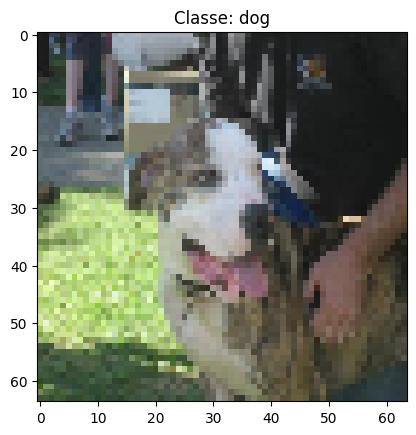

In [4]:
index = 0

print("Image shape: ", X_train[index].shape)
print("Label shape: ", y_train[index].shape)

print()


print("Image: ", X_train[index:index+1])
print("Label: ", y_train[index])

plt.imshow(X_train[index].astype("uint8"))
plt.title(f'Classe: {y_train[index]}')
plt.show()

# Preparing data

In [5]:
label_names = ['cat', 'dog']
label_encoder = LabelEncoder()
label_encoder.fit(label_names)

def preprocess_labels(labels):
    global label_encoder
    
    return label_encoder.transform(labels)

label_names = label_encoder.classes_
print(label_names)

y_test = preprocess_labels(y_test)
y_train = preprocess_labels(y_train)

['cat' 'dog']


In [6]:
y_train[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
rescale = Sequential([
    Rescaling(scale=1.0 / 255)
])

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
    rescale
])

def preprocess_images(images, batch_size=0):
    global data_augmentation
     
    if batch_size <= 0:
        print("Processing all images at once!")
        return np.asarray([data_augmentation(image) for image in images], dtype=np.float32)
    else:
        samples = len(images)
        num_batches = samples // batch_size
        if samples % batch_size > 0:
            num_batches += 1

        print(f"Processing {batch_size} images each step. Number of steps: {num_batches}!")
        processed_images = None
        for i in range(num_batches):
            
            start = i * batch_size
            end = start + batch_size
            if end > samples:
                end = samples

            if processed_images is None:
                processed_images = data_augmentation(images[start:end])
            else:
                processed_images = np.concatenate([processed_images, data_augmentation(images[start:end])])

        return np.asarray(processed_images, dtype=np.float32)

X_train_processed = preprocess_images(X_train, batch_size=250)

I0000 00:00:1721933066.336687  225970 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721933066.587274  225970 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721933066.587389  225970 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721933066.592298  225970 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721933066.592459  225970 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Processing 250 images each step. Number of steps: 16!


In [8]:
X_train_processed.shape

(4000, 64, 64, 3)

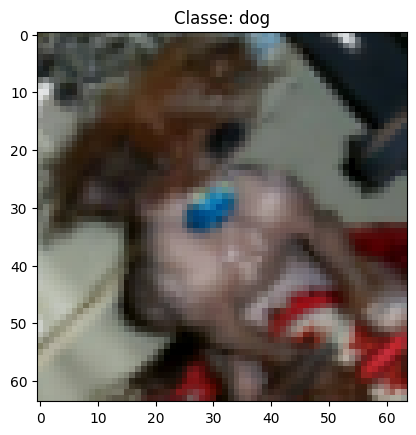

In [9]:
index = np.random.randint(0, X_train_processed.shape[0])

plt.imshow(X_train_processed[index])
plt.title(f'Classe: {label_names[y_train[index]]}')
plt.show()

In [10]:
shuffle = ShuffleSplit(n_splits=1, test_size=1)

X_train_processed_shuffle = None
y_train_shuffle = None
for i, (train_index, test_index) in enumerate(shuffle.split(X=X_train_processed, y=y_train)):
    indexes = np.concatenate([train_index, test_index])
    X_train_processed_shuffle = X_train_processed[indexes]
    print(X_train_processed_shuffle.shape)

    y_train_shuffle = y_train[indexes]
    print(y_train.shape)


(4000, 64, 64, 3)
(4000,)


# Getting the model

In [11]:
model_base_dir = os.path.join(
    os.getcwd(), 'models', 'cat_dog'
)

with open(os.path.join(model_base_dir, 'Cat_Dogs.model.json'), 'r') as json:
    model: Model = model_from_json(
        json_string = json.read()
    )

model.load_weights(
    filepath= os.path.join(model_base_dir, 'Cat_Dogs.weights.h5')
)
model.trainable = False # Freeze the base model
model.summary()

Model: "Cat_Dogs"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,248,485 (12.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,082,913 (4.13 MB)

 Optimizer params: 2,165,572 (8.26 MB)

# Checking model efficiency

In [12]:
results = model.evaluate(
    x=np.asarray(X_test),
    y=np.asarray(y_test),
    batch_size=1,
    verbose=1
)

loss = results[0]
accuracy = results[1]

print("Loss: ", loss)
print("Accuracy: ", accuracy)

2024-07-25 15:44:32.526557: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1721933072.699717  226304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933072.723294  226304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933072.755552  226304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933072.759715  226304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933072.762844  226304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933072.768705  226304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933072.771772  226304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933072.775226  226304 gpu_t

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.2289 - loss: 241.0291
Loss:  148.37179565429688
Accuracy:  0.39800000190734863


# Applying fine-tunning on dense layers

* Training with new data

In [13]:
# Unfreeze dense layers
for layer in model.layers:
    if 'dense' in layer.name:
        layer.trainable = True

model.summary(
    show_trainable=True
)

Model: "Cat_Dogs"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv2d_2 (Conv2D)           │ (None, 64, 64, 32)    │        896 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 64, 64, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_2             │ (None, 32, 32, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_3 (Conv2D)           │ (None, 32, 32, 32)    │     16,416 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_3       │ (None, 32, 32, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_3             │ (None, 16, 16, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 8192)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 128)           │  1,048,704 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 128)           │     16,512 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 3,248,485 (12.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,082,913 (4.13 MB)

 Optimizer params: 2,165,572 (8.26 MB)

In [14]:
import time

K = 5
kflod = StratifiedKFold(n_splits=K, shuffle=True)

results = []
index = 0
for train_index, test_index in kflod.split(X=X_train_processed_shuffle, y=y_train_shuffle):
    train = X_train_processed_shuffle[train_index]
    train_label = y_train_shuffle[train_index]

    test = (X_train_processed_shuffle[test_index], y_train_shuffle[test_index])

    now = time.time()
    print(f"K = {index+1} --> Fitting")
    result = model.fit(
        x=train,
        y=train_label,
        batch_size=32,
        epochs=100,
        validation_data=test,
        verbose=0
    )

    print(f"K = {index+1} ({round(time.time() - now,2)}s) --> Acc: {round(np.mean(result.history['accuracy']), 3)} | Loss: {round(np.mean(result.history['loss']), 3)}")
    index += 1
    results.append(result)

K = 1 --> Fitting


/home/jassy/repos/machine-learning/env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
W0000 00:00:1721933082.540636  226303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933082.544368  226303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933082.547927  226303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933082.551549  226303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933082.555416  226303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933082.559489  226303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721933082.564188  226303 gpu_

K = 1 (162.09s) --> Acc: 0.372 | Loss: 1.153
K = 2 --> Fitting
K = 2 (183.12s) --> Acc: 0.373 | Loss: 1.136
K = 3 --> Fitting


Treino - Acurácia média:	 0.3786762493848801
Treino - Cusot médio:	 1.1104645152091979
Teste - Acurácia média:	 0.3632499992847443
Teste - Cusot médio:	 1.0794766187667846


/tmp/ipykernel_70132/3667198355.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_70132/3667198355.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_70132/3667198355.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()
/tmp/ipykernel_70132/3667198355.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend()


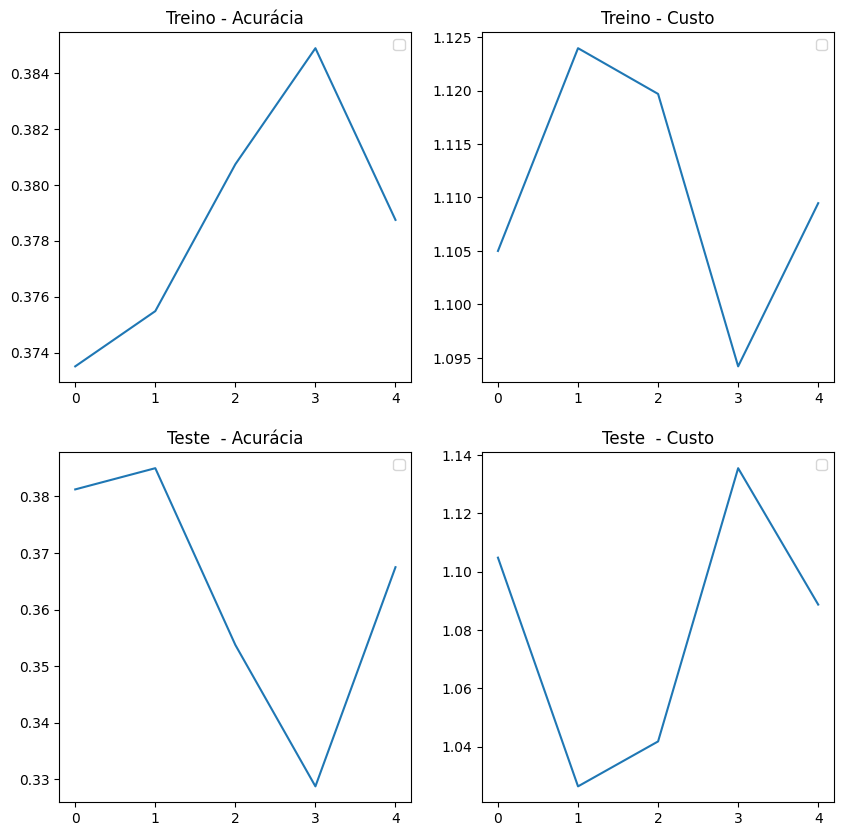

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2
)

ax1.set_title("Treino - Acurácia")
ax2.set_title("Treino - Custo")
ax3.set_title("Teste  - Acurácia")
ax4.set_title("Teste  - Custo")

train_acc = [np.mean(item.history['accuracy']) for item in results]
train_loss = [np.mean(item.history['loss']) for item in results]
test_acc = [np.mean(item.history['val_accuracy']) for item in results]
test_loss = [np.mean(item.history['val_loss']) for item in results]

print("Treino - Acurácia média:\t", np.mean(train_acc))
print("Treino - Cusot médio:\t", np.mean(train_loss))

print("Teste - Acurácia média:\t", np.mean(test_acc))
print("Teste - Cusot médio:\t", np.mean(test_loss))

ax1.plot(train_acc)
ax2.plot(train_loss)
ax3.plot(test_acc)
ax4.plot(test_loss)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.show()

# Applying fine-tunning with new dense layers

In [ ]:
model_base_dir = os.path.join(
    os.getcwd(), 'models', 'cat_dog'
)

with open(os.path.join(model_base_dir, 'Cat_Dogs.model.json'), 'r') as json:
    network: Sequential = model_from_json(
        json_string = json.read()
    )

network.load_weights(
    filepath= os.path.join(model_base_dir, 'Cat_Dogs.weights.h5')
)

# network.trainable = False

network.compile(
    optimizer=Adam(),
    metrics=[
        BinaryAccuracy(),
        RootMeanSquaredError()
    ],
    loss=Hinge(),
    jit_compile=True
)

# Unfreeze dense layers
for index in range(len(network.layers)):
    if not 'dense' in network.layers[index].name:
        network.layers[index].trainable = False

network.summary(show_trainable=True)


Model: "Cat_Dogs"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv2d_2 (Conv2D)           │ (None, 64, 64, 32)    │        896 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 64, 64, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_2             │ (None, 32, 32, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_3 (Conv2D)           │ (None, 32, 32, 32)    │     16,416 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_3       │ (None, 32, 32, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_3             │ (None, 16, 16, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 8192)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 128)           │  1,048,704 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 128)           │     16,512 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 1,082,913 (4.13 MB)

 Trainable params: 1,065,345 (4.06 MB)

 Non-trainable params: 17,568 (68.62 KB)

In [ ]:
network.save("model.keras")

In [ ]:
network.fit(
    x=X_train_processed,
    y=y_train,
    batch_size=64,
    epochs=150,
    verbose=2
)

In [ ]:
network.evaluate(x=X_test_reshaped, y=y_test)